## Linear models for predicting MLB salary in 6 years with rookie stats

### Future notes / todos
* Distribution of log(salary) is somewhat normal. Need to confirm if this is OK or not.
* Should put age into feature set and see if the younger the rookie then better chance of a higher salary.
* Need some type of pairplot as probably some of my features are correlated like HRs and TBs.
* Probably need to get more data

In [104]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from  matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

# %config InlineBackend.figure_format = 'svg'
%matplotlib inline

%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [105]:
# set paths of the data files
PATH_S = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/hist_salaries.csv'
PATH_R = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookies.csv'
PATH_RS = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/agg_df_stats.csv'

In [106]:
def mean_mse_Lasso(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [107]:
def mean_mse_Ridge(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [108]:
# get the salary and stats data
df_stats = pd.read_csv(PATH_RS, index_col = 0)
df_salary = pd.read_csv(PATH_S, index_col = 0)

Merge the stats and salary data frames together. `df_stats` has only rookie batters from 1985-2017. `df_salary` has all MLB salaries from 1985-2017 as long as the player was paid for 6 years from rookie season.

In [109]:
salary_stats_df = df_stats.merge(df_salary, on='name_year')
salary_stats_df = salary_stats_df.loc[:,['Year_x', 'Age_x', 'name_x', 'debut', 'position', 'G', 'PA', 'AB', 'R',
       'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'name_year',
        'Salary', 'SrvTm', 'today_salary']]
salary_stats_df.rename(columns={'Year_x':'rookie_year', 'Age_x':'age', 'name_x':'name'}, inplace=True)
salary_stats_df['log_today_salary'] = np.log10(salary_stats_df.today_salary) # log transform the salary
salary_stats_df.shape

(919, 23)

Create `X` and `y`, and make a train / test split of 20%.

In [110]:
y = salary_stats_df.log_today_salary

X = salary_stats_df.loc[:,['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'age']]
print('X sample:',X.shape)
print('y sample:',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print('X train:', X_train.shape)
print('y train:', y_train.shape)

X sample: (919, 14)
y sample: (919,)
X train: (735, 14)
y train: (735,)


Combine `X` and `y` training data sets and calculate the correlation matrix.

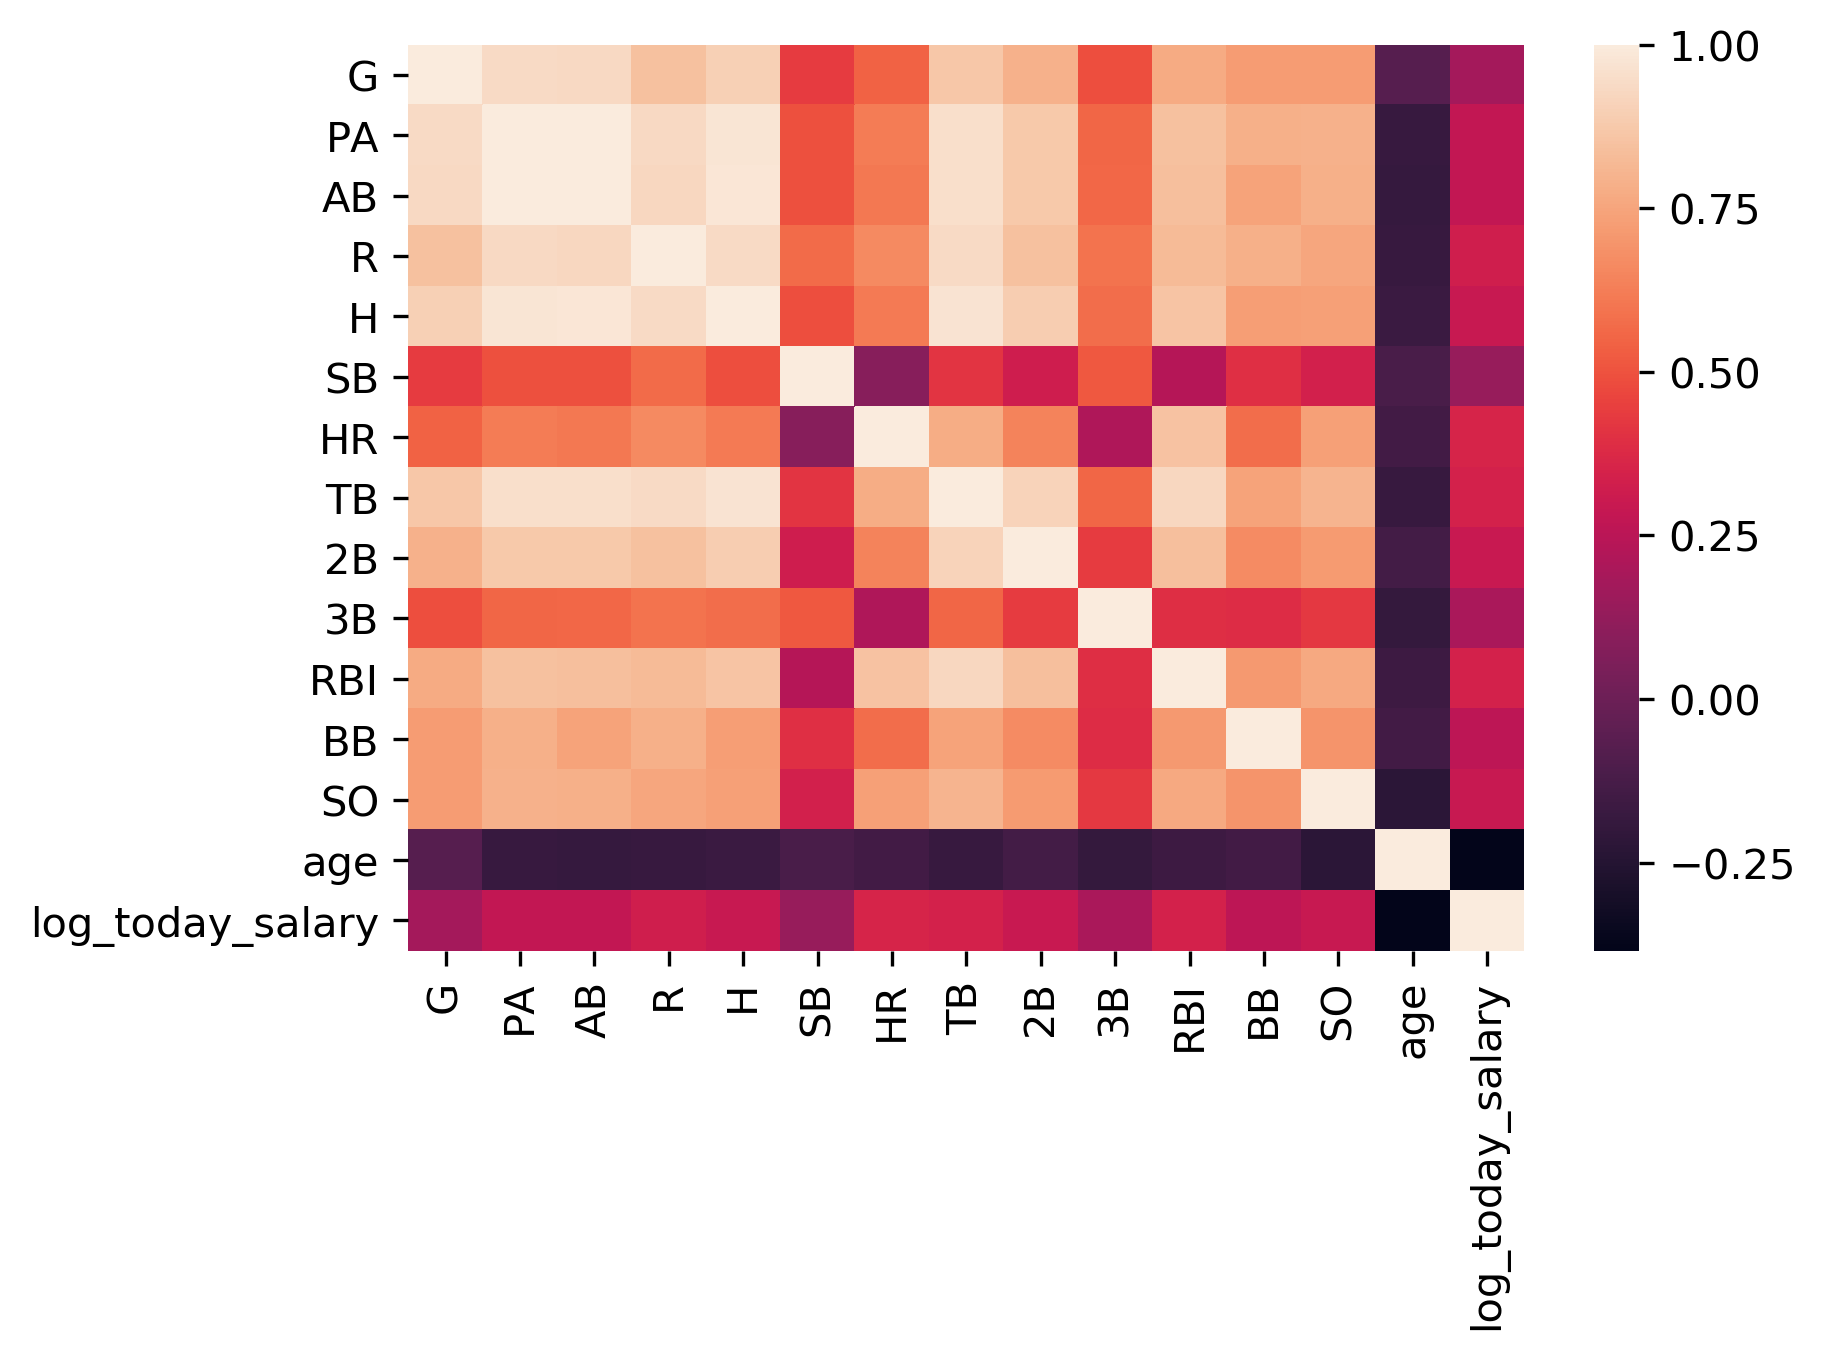

In [111]:
Xy = pd.concat([X_train, y_train], axis=1)
# sns.pairplot(Xy);

corr = Xy.corr()
sns.heatmap(corr);

HRs and age of rookie year are somewhat correlated with salary in 6 years. Whereas, games (G) and stolen bases (SB) are less related to salary in 6 years.

Build a basic linear regression model with all features as a baseline to compare against the Lasso models

In [112]:
model_results = pd.Series(name='MSE')

Add a 10-fold cross-validation linear regression model.

In [113]:
lin_model = LinearRegression()
scores = cross_val_score(lin_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
model_results['linear model - cv10'] = np.mean(-scores)
model_results

linear model - cv10    0.163087
Name: MSE, dtype: float64

Build a Lasso model with standard scaling.

Now perform a 10-fold cross validation for same range of alphas.

In [114]:
alphas = [10**a for a in range(-2,5)]

In [115]:
cv_lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, alphas=alphas, tol=0.001))
cv_lasso.fit(X_train, y_train)
model_results['lasso cv - ' + str(cv_lasso.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso, 'lassocv')
model_results.sort_values()

lasso cv - 0.01        0.162541
linear model - cv10    0.163087
Name: MSE, dtype: float64

Now 2-5 degree polynomial features and perform a 10-fold cross validation.

In [116]:
for degrees in range(2,6):
    cv_lasso_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), LassoCV(cv=10, alphas=alphas,tol=0.001))
    cv_lasso_poly.fit(X_train, y_train)
    model_results['lasso poly ' + str(degrees) + ' cv - ' + str(cv_lasso_poly.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso_poly, 'lassocv')

In [117]:
model_results.sort_values()

lasso poly 3 cv - 0.01    0.161218
lasso poly 2 cv - 0.01    0.161348
lasso poly 4 cv - 0.01    0.161483
lasso poly 5 cv - 0.01    0.162328
lasso cv - 0.01           0.162541
linear model - cv10       0.163087
Name: MSE, dtype: float64

In [118]:
## Talk to Spencer tomorrow possibly
# ## Broken need to use the cv_values_
# for degrees in range(2,3):
#     cv_ridge_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), RidgeCV(cv=10, alphas=alphas))
#     cv_ridge_poly.fit(X_train, y_train)
# #     model_results['ridge poly ' + str(degrees) + ' cv - ' + str(cv_ridge_poly.get_params()['ridgecv'].alpha_)] = mean_mse(cv_ridge_poly, 'ridgecv')

In [119]:
# cv_ridge_poly.get_params()['ridgecv'].alpha_

In [120]:
# model_results.sort_values()

In [121]:
best_model = make_pipeline(PolynomialFeatures(3), StandardScaler(), LassoCV(cv=10, alphas=alphas, tol=0.001))
best_model.fit(X_train, y_train);

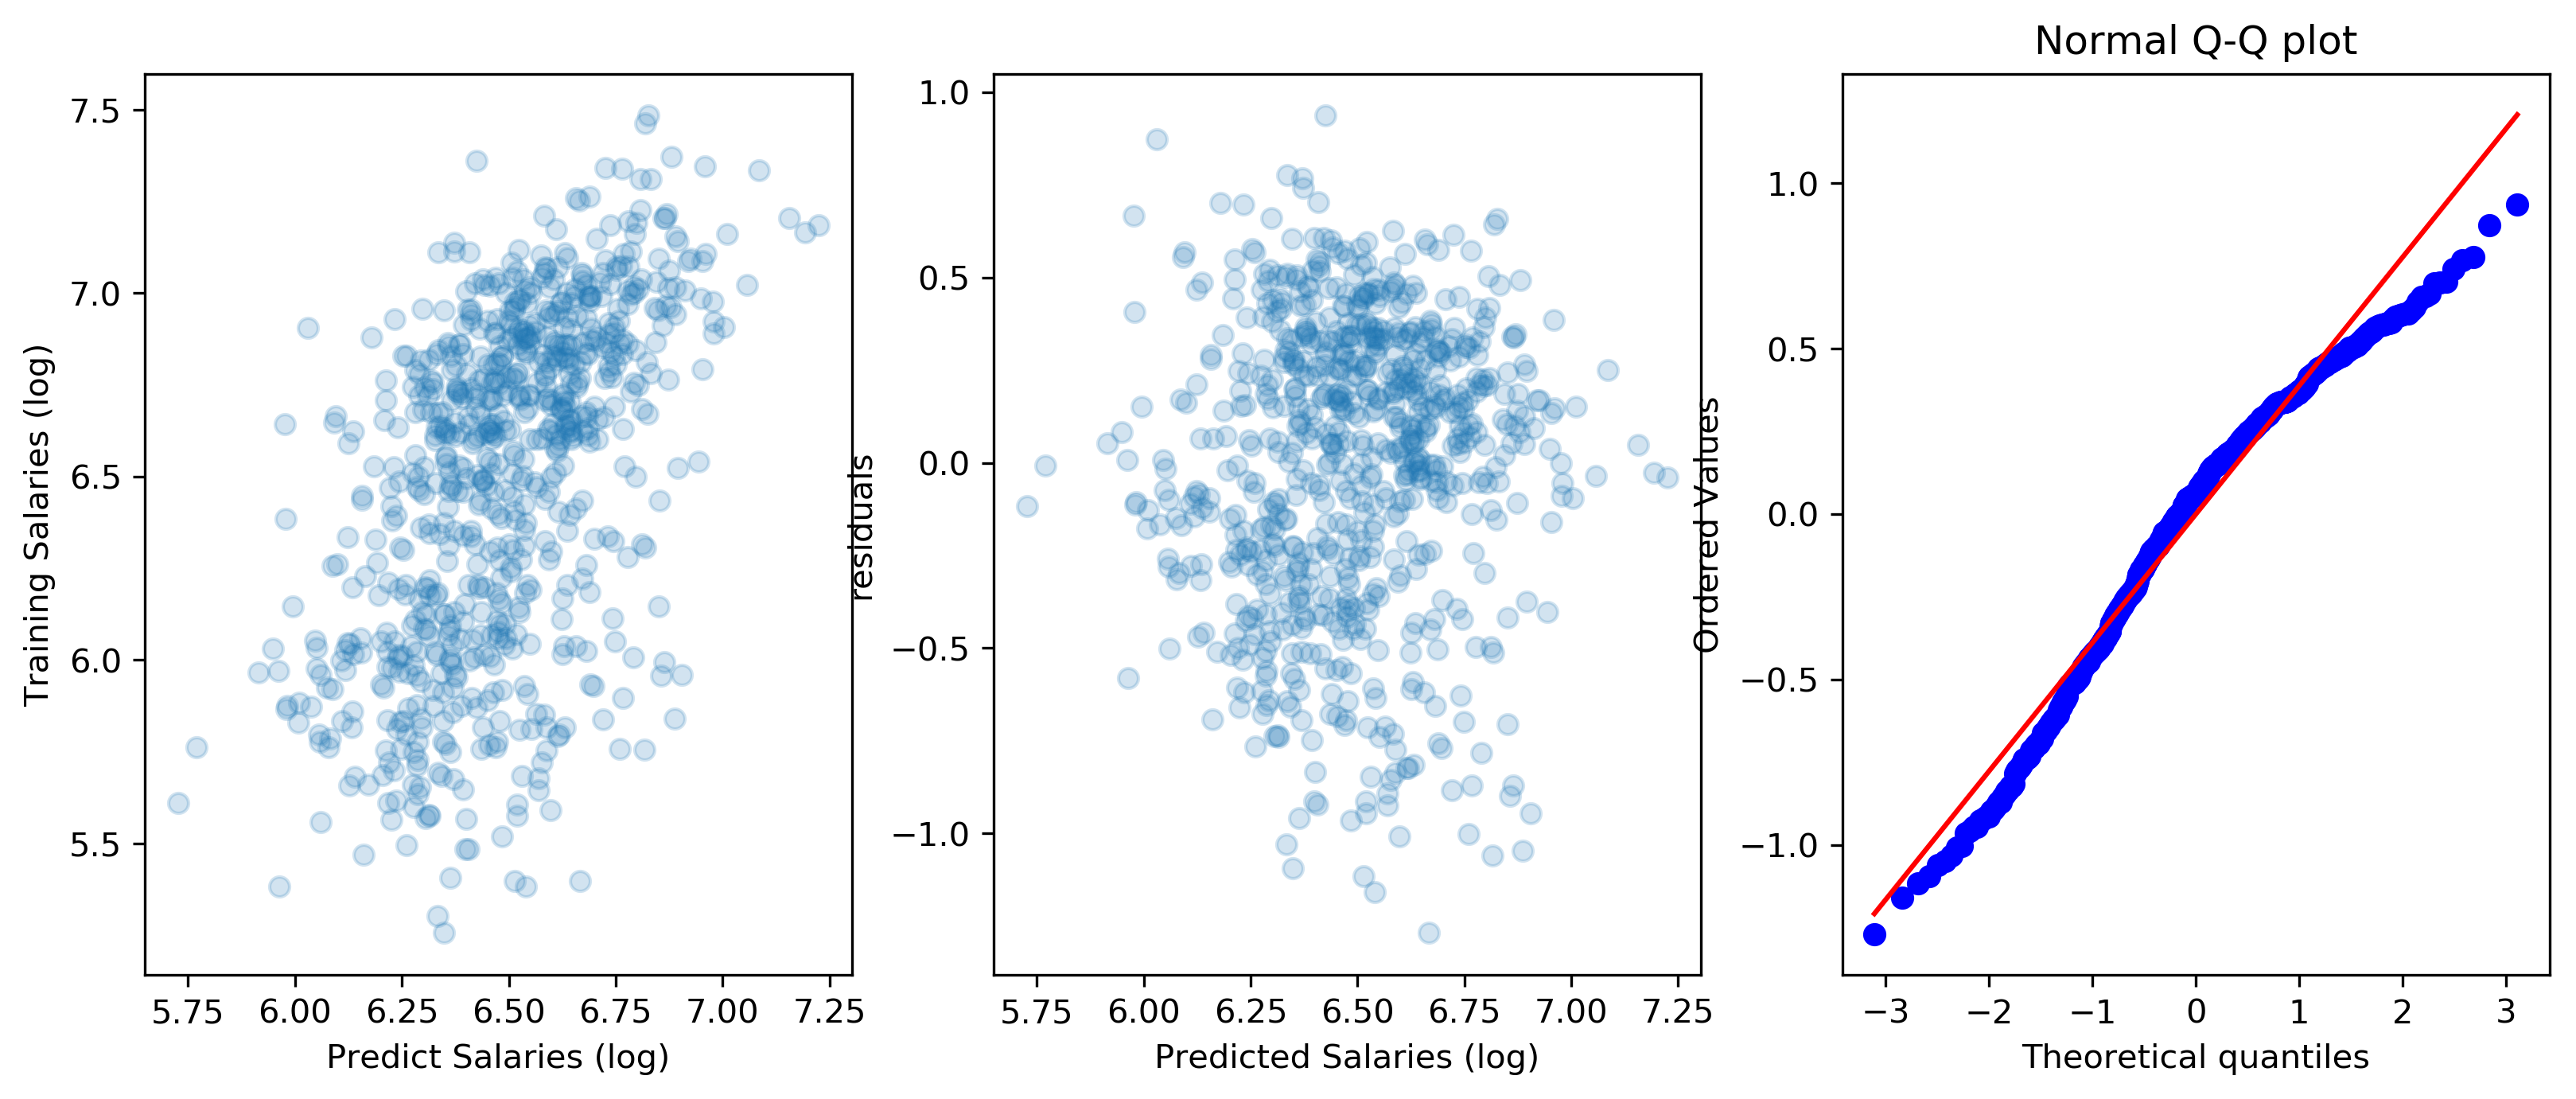

In [122]:
plt.figure(figsize=(13,5))
# plt.subplots(1,3)

# scatter y-train and y-pred
plt.subplot(1,3,1)
plt.scatter(best_model.predict(X_train), y_train, alpha=0.2)
plt.xlabel('Predict Salaries (log)')
plt.ylabel('Training Salaries (log)')

# residual plot
plt.subplot(1,3,2)
res = y_train - best_model.predict(X_train)
plt.scatter(best_model.predict(X_train), res, alpha = 0.2)
plt.xlabel('Predicted Salaries (log)')
plt.ylabel('residuals')

# Q-Q plot
plt.subplot(1, 3, 3)
#Generates a probability plot of sample data against the quantiles of a 
# specified theoretical distribution 
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

In [123]:
print('Train MSE:', mean_squared_error(y_train, best_model.predict(X_train)))
print('Test MSE:',mean_squared_error(y_test, best_model.predict(X_test)), end='\n\n')

print('Train R^2:', best_model.score(X_train, y_train))
print('Test R^2:', best_model.score(X_test, y_test))

Train MSE: 0.15447006180621878
Test MSE: 0.15361197831972048

Train R^2: 0.2737217151830147
Test R^2: 0.26688101673872344


In [157]:
errors = pd.DataFrame()
errors['observed'] = 10**y_test
errors['predicted'] = 10**best_model.predict(X_test)
errors['error'] = errors.observed - errors.predicted
errors['percent_error'] = (errors.observed - errors.predicted) / errors.predicted

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


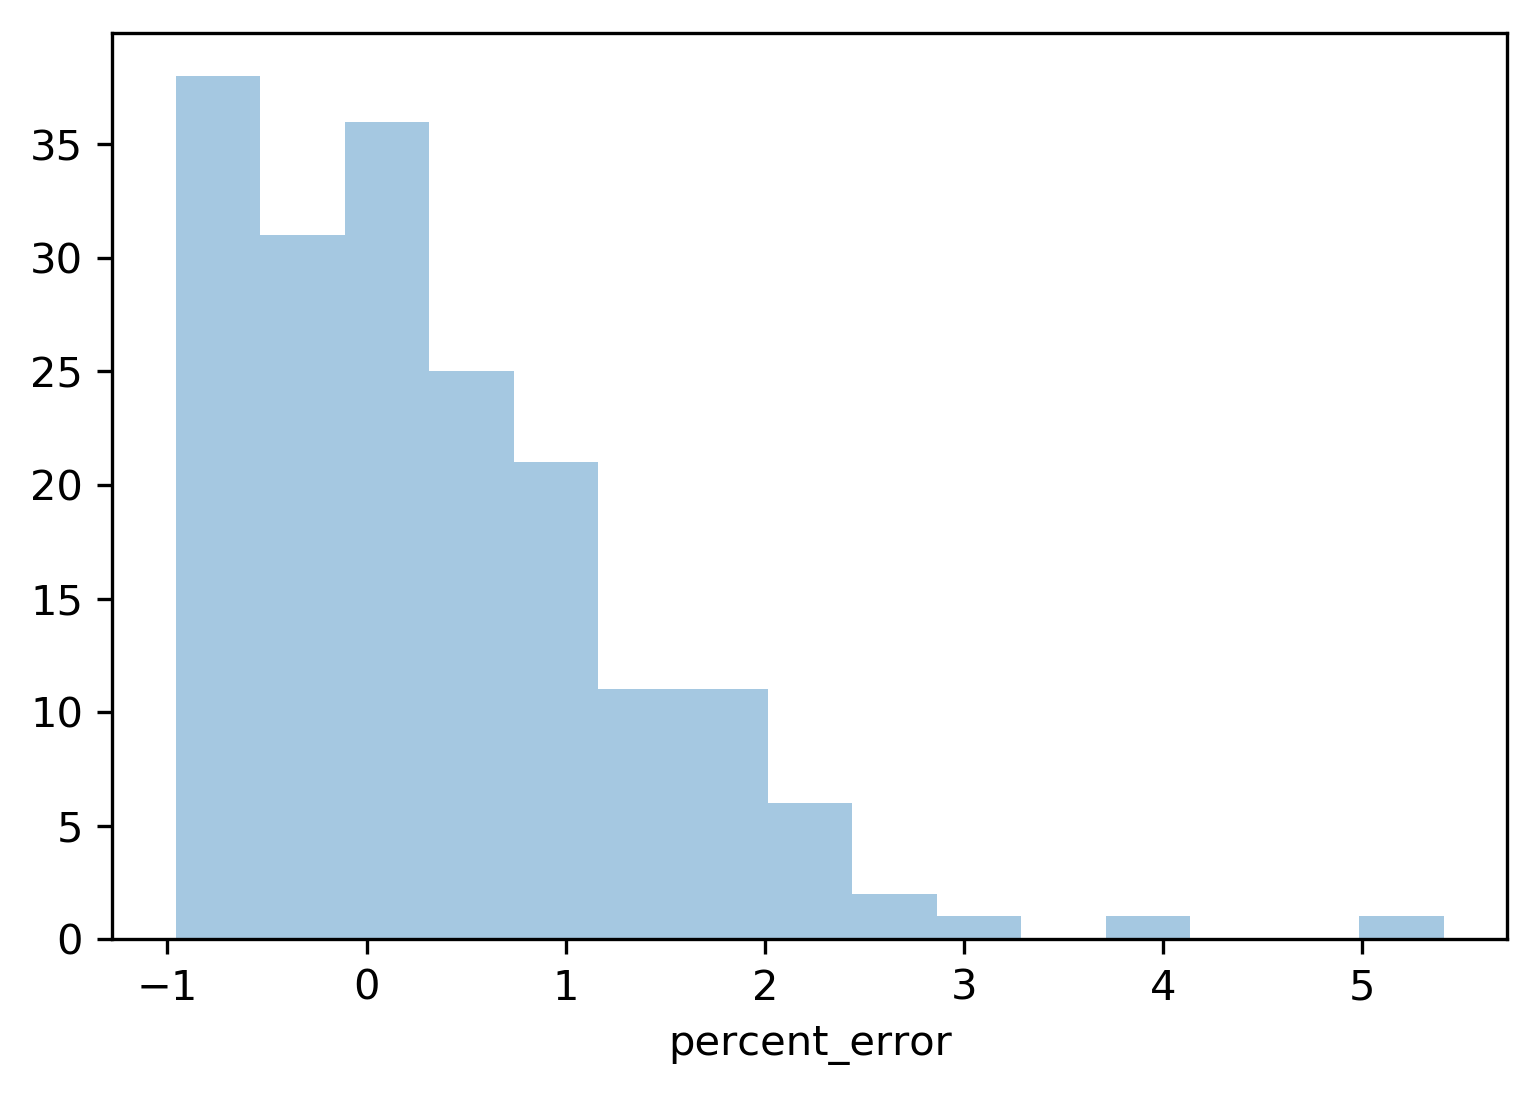

In [158]:
sns.distplot(errors.percent_error, kde=False);

In [184]:
errors['cats'] = ''
errors['sort'] = np.nan
g = [-1,-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 10]# 0.03, 0.06, 0.09, 0.12, 0.15, 10]
l = ['-100-75%', '-75-50%', '-50-25%', '-25-0%', '0-25%', '25-50%', '50-75%','50-75%','>100%']
g[:-1]
for k, b in enumerate(g[:-1]):
#     print(b, g[k+1], l[k])
    sub = (errors.percent_error >= b) & (errors.percent_error < g[k+1])
    errors.loc[sub,'cats'] = l[k]
# errors[errors.percent_error == '','cats'] = '>15%'
error_cat = errors.groupby('cats')['percent_error'].count().reset_index()

In [185]:
errors[errors.cats=='']

,observed,predicted,error,percent_error,cats,sort


In [191]:
mean_salary = errors.groupby('cats')['observed'].mean().reset_index()
mean_salary

,cats,observed
0,-100-75%,5.044840e+05
1,-25-0%,3.595142e+06
2,-50-25%,2.020948e+06
3,-75-50%,1.376756e+06
4,0-25%,4.735198e+06
5,25-50%,6.115813e+06
6,50-75%,7.643788e+06
7,>100%,9.582967e+06


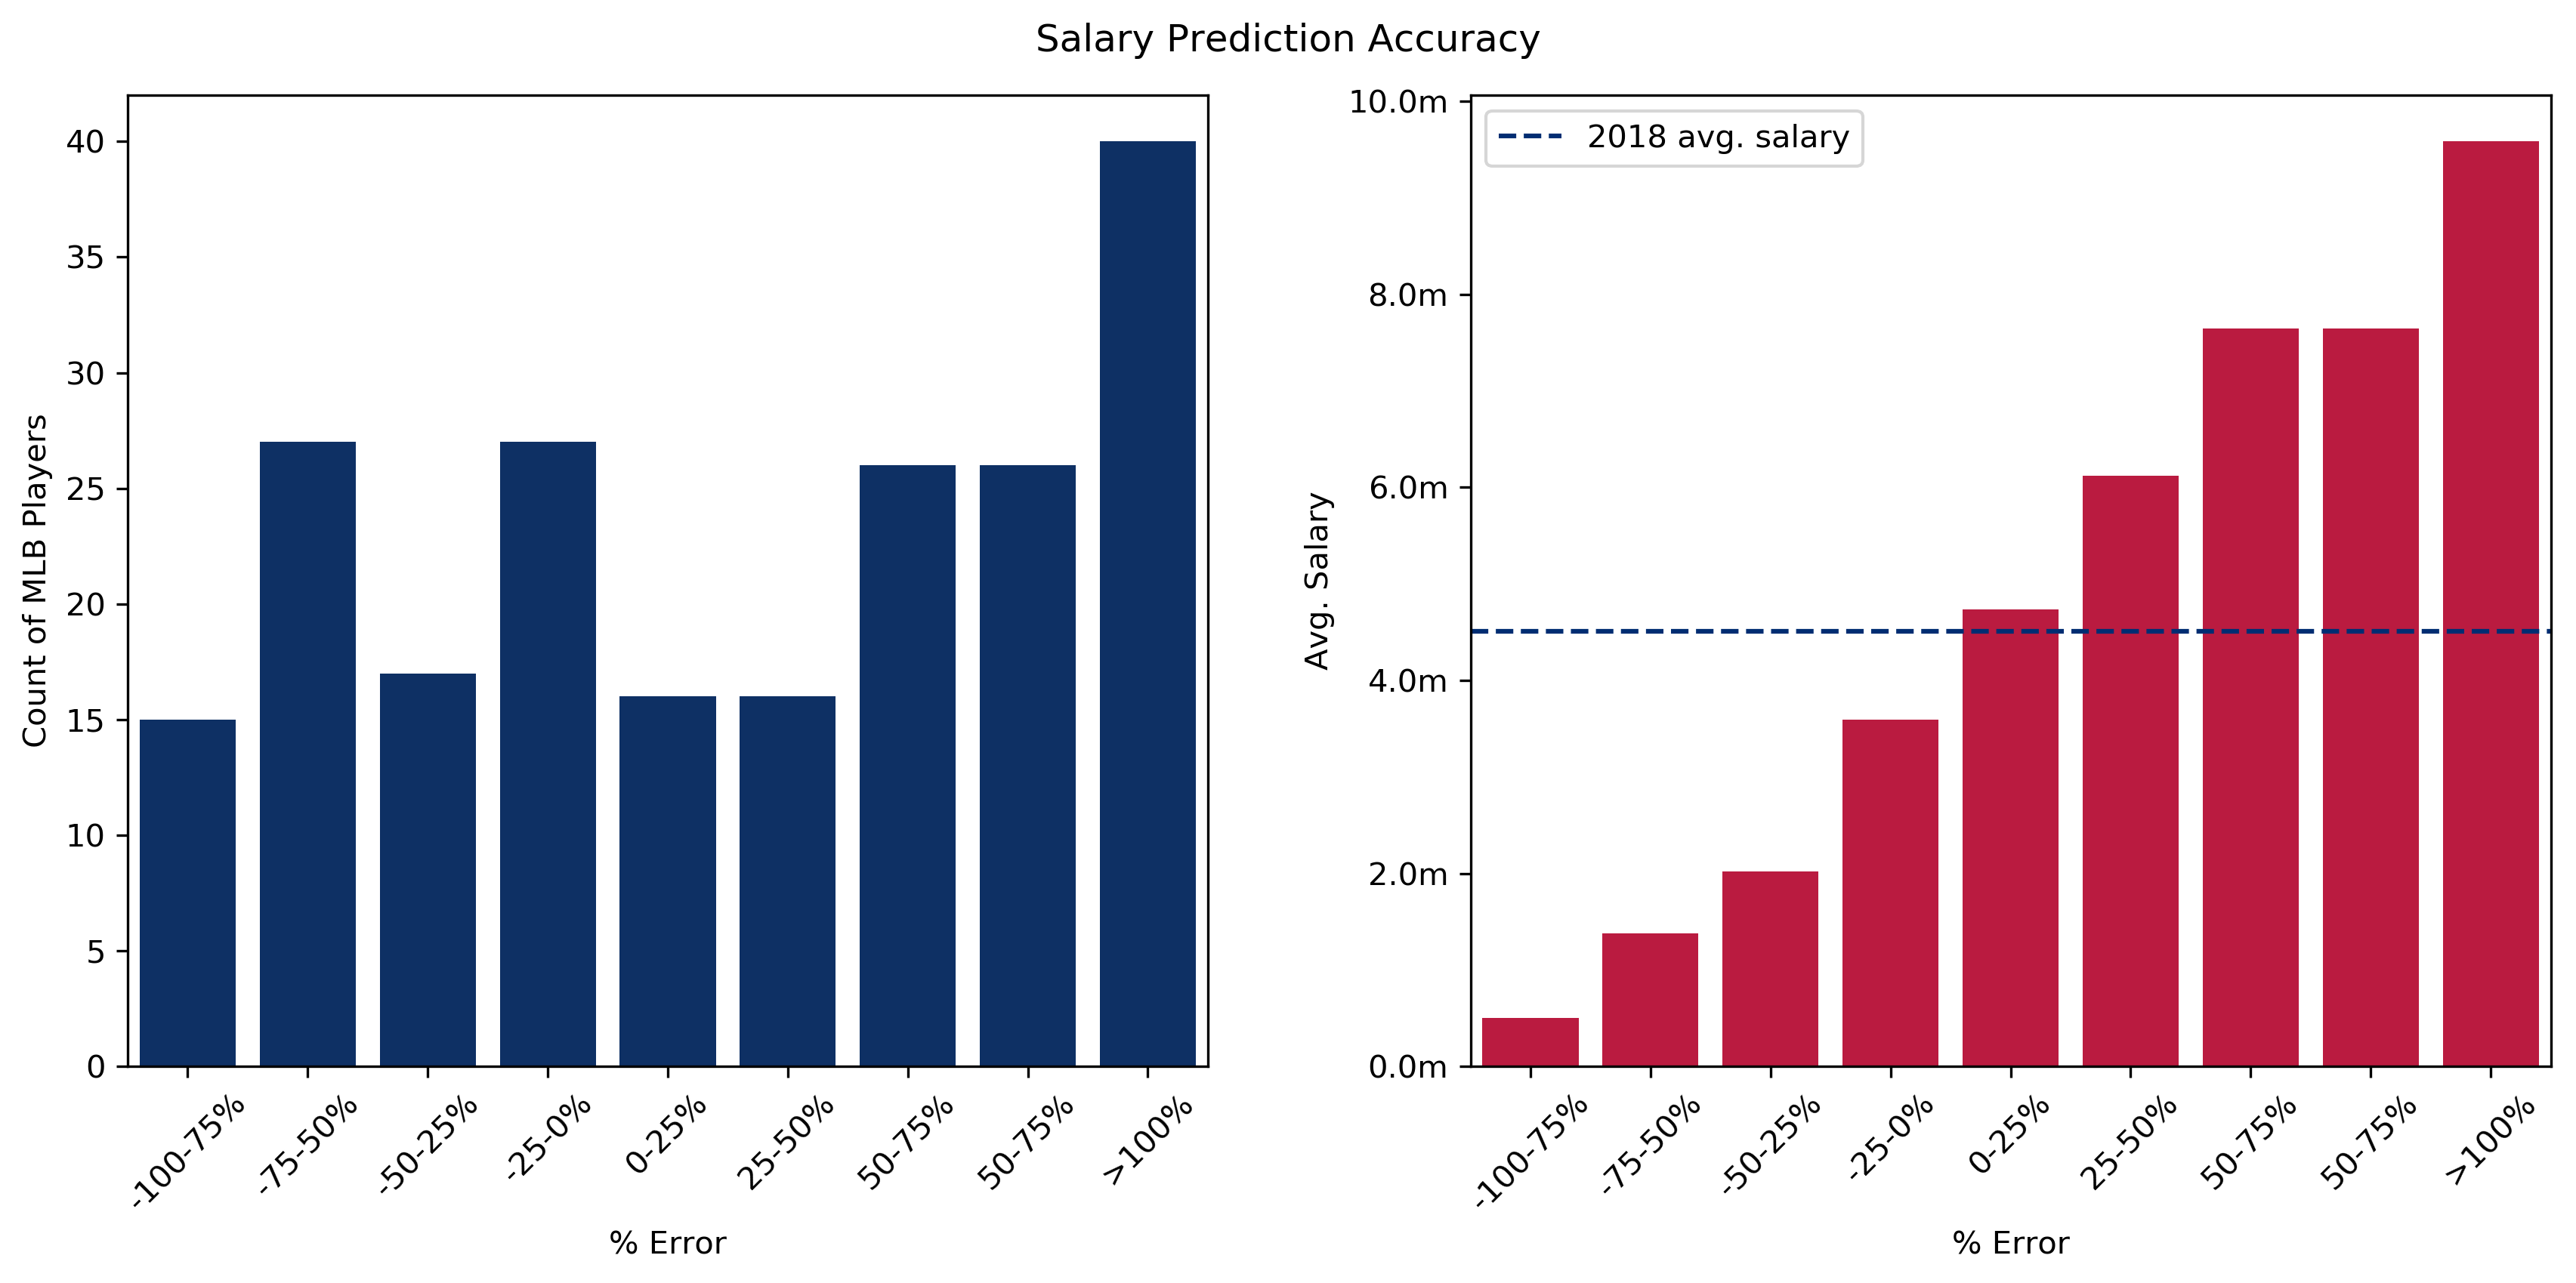

In [216]:
# plt.subplots(1,2)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.barplot(x=error_cat.cats, y=error_cat.percent_error, order=l, color='#002D72')

plt.xlabel('% Error')
plt.ylabel('Count of MLB Players')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(x=mean_salary.cats, y=mean_salary.observed, order=l, color='#D50032')
plt.axhline(y=4.51e6, color='#002D72', linestyle='--',label='2018 avg. salary')

plt.xlabel('% Error')
plt.ylabel('Avg. Salary')
plt.xticks(rotation=45)
plt.legend()
# convert tick labels to millions
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{}m'.format(x/1e6) for x in vals])

plt.suptitle('Salary Prediction Accuracy')
plt.tight_layout(pad=3)
plt.savefig('misc/salary_prediction_accuracy.png');

There are a large span of errors. If we look at the average actual salary in the same buckets, then the players with higher salaries in year 6 are harder to predict, and likewise lower salaries are also difficlt to predict. Players who are expected to make in the range of the league average are easier to predict. League average salary is 4.5M for 2018.

In [161]:
bad_errors = errors[errors.cats=='>100%'].sort_values('percent_error')
bad_errors

,observed,predicted,error,percent_error,cats,sort
110,7.277517e+06,3.635668e+06,3.641849e+06,1.001700,>100%,NaN
109,4.410617e+06,2.146842e+06,2.263775e+06,1.054467,>100%,NaN
468,9.413210e+06,4.542609e+06,4.870602e+06,1.072204,>100%,NaN
879,7.900000e+06,3.808980e+06,4.091020e+06,1.074046,>100%,NaN
210,4.123514e+06,1.980248e+06,2.143266e+06,1.082322,>100%,NaN
429,8.823801e+06,4.136590e+06,4.687211e+06,1.133110,>100%,NaN
296,8.896632e+06,4.161296e+06,4.735336e+06,1.137947,>100%,NaN
350,8.515842e+06,3.913939e+06,4.601903e+06,1.175773,>100%,NaN
299,1.423461e+07,6.527311e+06,7.707300e+06,1.180777,>100%,NaN
213,3.563530e+06,1.632700e+06,1.930830e+06,1.182600,>100%,NaN


In [218]:
salary_stats_df.loc[salary_stats_df.name=='Bryce Harper']

,rookie_year,age,name,debut,position,G,PA,AB,R,H,...,2B,3B,RBI,BB,SO,name_year,Salary,SrvTm,today_salary,log_today_salary
867,2012,19.0,Bryce Harper,2012-04-28,Outfielder,139.0,597.0,533.0,98.0,144.0,...,26.0,9.0,59.0,56.0,120.0,Bryce Harper_2012,21625000.0,5.159,21625000.0,7.334956


In [227]:
train_errors = pd.DataFrame()
train_errors['observed'] = 10**y_train
train_errors['predicted'] = 10**best_model.predict(X_train)
train_errors['error'] = train_errors.observed - train_errors.predicted
train_errors['percent_error'] = (train_errors.observed - train_errors.predicted) / train_errors.predicted

In [228]:
train_errors.loc[867]

observed         2.162500e+07
predicted        1.206313e+07
error            9.561869e+06
percent_error    7.926523e-01
Name: 867, dtype: float64

In [163]:
[y_test[880],10**y_test[880]]

[7.1180993120779945, 13125000.0]

In [162]:
salary_stats_df.loc[880,['log_today_salary','today_salary']]

log_today_salary        7.1181
today_salary        1.3125e+07
Name: 880, dtype: object

In [170]:
salary_stats_df.join(bad_errors,how='inner').describe()

,rookie_year,age,G,PA,AB,R,H,SB,HR,TB,...,SO,Salary,SrvTm,today_salary,log_today_salary,observed,predicted,error,percent_error,sort
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,...,39.000000,3.900000e+01,39.000000,3.900000e+01,39.000000,3.900000e+01,3.900000e+01,3.900000e+01,39.000000,0.0
mean,2001.717949,24.153846,92.410256,337.538462,304.230769,41.410256,83.846154,5.461538,7.282051,125.435897,...,50.923077,7.988095e+06,1.846128,9.470271e+06,6.927206,9.470271e+06,3.562034e+06,5.908237e+06,1.700855,NaN
std,7.850406,1.814249,37.565885,163.546524,149.158951,26.719516,49.309196,9.469747,6.185504,73.486051,...,27.741651,4.166313e+06,2.688570,4.688115e+06,0.211726,4.688115e+06,1.690959e+06,3.241184e+06,0.620380,NaN
min,1988.000000,22.000000,20.000000,65.000000,55.000000,1.000000,6.000000,0.000000,0.000000,7.000000,...,11.000000,2.333333e+06,0.000000,2.856384e+06,6.455817,2.856384e+06,8.811114e+05,1.930830e+06,1.001700,NaN
25%,1995.000000,23.000000,66.000000,227.500000,201.000000,21.500000,53.000000,1.000000,3.500000,78.500000,...,32.000000,5.675000e+06,0.000000,7.044569e+06,6.847844,7.044569e+06,2.479713e+06,3.995965e+06,1.202288,NaN
50%,2002.000000,24.000000,85.000000,303.000000,277.000000,34.000000,73.000000,3.000000,5.000000,105.000000,...,45.000000,7.333333e+06,0.000000,8.823801e+06,6.945656,8.823801e+06,3.312763e+06,4.870602e+06,1.700302,NaN
75%,2008.000000,25.000000,118.000000,432.000000,380.000000,53.000000,107.000000,6.000000,10.000000,181.500000,...,67.000000,1.017500e+07,5.087000,1.069699e+07,7.029203,1.069699e+07,4.148943e+06,6.890915e+06,2.027313,NaN
max,2015.000000,29.000000,163.000000,738.000000,692.000000,127.000000,242.000000,56.000000,28.000000,316.000000,...,129.000000,2.300000e+07,7.009000,2.455535e+07,7.390146,2.455535e+07,8.802358e+06,1.575299e+07,3.935281,NaN


In [141]:
salary_stats_df.sort_values('today_salary',ascending=False)

,rookie_year,age,name,debut,position,G,PA,AB,R,H,...,2B,3B,RBI,BB,SO,name_year,Salary,SrvTm,today_salary,log_today_salary
869,2012,20.0,Mike Trout,2011-07-08,Centerfielder,139.0,639.0,559.0,129.0,182.0,...,27.0,8.0,83.0,67.0,139.0,Mike Trout_2012,34083000.0,6.070,3.408300e+07,7.532538
317,1995,19.0,Alex Rodriguez,1994-07-08,Shortstop and Third Baseman,48.0,149.0,142.0,15.0,33.0,...,6.0,2.0,19.0,6.0,42.0,Alex Rodriguez_1995,22000000.0,0.000,3.044969e+07,7.483583
894,2012,26.0,Yoenis Cespedes,2012-03-28,Leftfielder,129.0,540.0,487.0,70.0,142.0,...,25.0,5.0,82.0,43.0,102.0,Yoenis Cespedes_2012,29000000.0,6.000,2.900000e+07,7.462398
668,2006,22.0,Prince Fielder,2005-06-13,First Baseman,157.0,648.0,569.0,82.0,154.0,...,35.0,1.0,81.0,59.0,125.0,Prince Fielder_2006,23000000.0,6.068,2.455535e+07,7.390146
571,2003,23.0,Mark Teixeira,2003-04-01,First Baseman,146.0,589.0,529.0,66.0,137.0,...,29.0,5.0,84.0,44.0,120.0,Mark Teixeira_2003,20625000.0,0.000,2.356517e+07,7.372271
891,2012,26.0,Josh Donaldson,2010-04-30,Third Baseman,75.0,294.0,274.0,34.0,66.0,...,16.0,0.0,33.0,14.0,61.0,Josh Donaldson_2012,23000000.0,5.158,2.300000e+07,7.361728
796,2010,20.0,Jason Heyward,2010-04-05,Rightfielder,142.0,623.0,520.0,83.0,144.0,...,29.0,5.0,72.0,91.0,128.0,Jason Heyward_2010,21666666.0,6.000,2.212824e+07,7.344947
752,2008,24.0,Jacoby Ellsbury,2007-06-30,Centerfielder,145.0,609.0,554.0,98.0,155.0,...,22.0,7.0,47.0,41.0,80.0,Jacoby Ellsbury_2008,21142857.0,6.037,2.189163e+07,7.340278
652,2005,25.0,Ryan Howard,2004-09-01,First Baseman,88.0,348.0,312.0,52.0,90.0,...,17.0,2.0,63.0,33.0,100.0,Ryan Howard_2005,20000000.0,5.145,2.179435e+07,7.338344
867,2012,19.0,Bryce Harper,2012-04-28,Outfielder,139.0,597.0,533.0,98.0,144.0,...,26.0,9.0,59.0,56.0,120.0,Bryce Harper_2012,21625000.0,5.159,2.162500e+07,7.334956


In [128]:
best_model.fit(X,y)
print('MSE:', mean_squared_error(y, best_model.predict(X)))
print('R^2:', best_model.score(X,y))

MSE: 0.15354176468859418
R^2: 0.2760381001440161
